In [6]:
%matplotlib inline
import sys
print(sys.executable)
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import math

# Image manipulation.
from PIL import Image
from scipy.ndimage.filters import gaussian_filter

/usr/bin/python3


In [7]:
import inception5h

In [8]:
inception5h.maybe_download()

Data has apparently already been downloaded and unpacked.


In [9]:
model = inception5h.Inception5h()

Instructions for updating:
Use tf.gfile.GFile.


In [10]:
len(model.layer_tensors)

12

In [11]:
# to know the different layers in the inception 5h model
import tensorflow as tf

def printTensors(pb_file):

    # read pb into graph_def
    with tf.gfile.GFile(pb_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # import graph_def
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)

    # print operations
    for op in graph.get_operations():
        print(op.name)


printTensors("inception/5h/tensorflow_inception_graph.pb")


import/input
import/conv2d0_w
import/conv2d0_b
import/conv2d1_w
import/conv2d1_b
import/conv2d2_w
import/conv2d2_b
import/mixed3a_1x1_w
import/mixed3a_1x1_b
import/mixed3a_3x3_bottleneck_w
import/mixed3a_3x3_bottleneck_b
import/mixed3a_3x3_w
import/mixed3a_3x3_b
import/mixed3a_5x5_bottleneck_w
import/mixed3a_5x5_bottleneck_b
import/mixed3a_5x5_w
import/mixed3a_5x5_b
import/mixed3a_pool_reduce_w
import/mixed3a_pool_reduce_b
import/mixed3b_1x1_w
import/mixed3b_1x1_b
import/mixed3b_3x3_bottleneck_w
import/mixed3b_3x3_bottleneck_b
import/mixed3b_3x3_w
import/mixed3b_3x3_b
import/mixed3b_5x5_bottleneck_w
import/mixed3b_5x5_bottleneck_b
import/mixed3b_5x5_w
import/mixed3b_5x5_b
import/mixed3b_pool_reduce_w
import/mixed3b_pool_reduce_b
import/mixed4a_1x1_w
import/mixed4a_1x1_b
import/mixed4a_3x3_bottleneck_w
import/mixed4a_3x3_bottleneck_b
import/mixed4a_3x3_w
import/mixed4a_3x3_b
import/mixed4a_5x5_bottleneck_w
import/mixed4a_5x5_bottleneck_b
import/mixed4a_5x5_w
import/mixed4a_5x5_b
import/

In [12]:
# to load the image using PIL
def load_image(filename):
    try:
        original = Image.open(filename)
        print("the size of the image is :")
        print(original.format,original.size)
    except:
        print ("Unable to load image")

    return np.float32(original)

In [13]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        Image.fromarray(image).save(file, 'jpeg')

In [14]:
def plot_image(image):
    # Assume the pixel-values are scaled between 0 and 255.
    
    if False:
        # Convert the pixel-values to the range between 0.0 and 1.0
        image = np.clip(image/255.0, 0.0, 1.0)
        
        # Plot using matplotlib.
        plt.imshow(image, interpolation='lanczos')
        plt.show()
    else:
        # Ensure the pixel-values are between 0 and 255.
        image = np.clip(image, 0.0, 255.0)
        
        # Convert pixels to bytes.
        image = image.astype(np.uint8)

        # Convert to a PIL-image and display it.
        display(Image.fromarray(image))

In [15]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)
    
    return x_norm

In [16]:
def plot_gradient(gradient):
    # Normalize the gradient so it is between 0.0 and 1.0
    gradient_normalized = normalize_image(gradient)
    
    # Plot the normalized gradient.
    plt.imshow(gradient_normalized, interpolation='bilinear')
    plt.show()

In [17]:
def resize_image(image, size=None, factor=None):
    # If a rescaling-factor is provided then use it.
    if factor is not None:
        # Scale the numpy array's shape for height and width.
        size = np.array(image.shape[0:2]) * factor
        
        # The size is floating-point because it was scaled.
        # PIL requires the size to be integers.
        size = size.astype(int)
    else:
        # Ensure the size has length 2.
        size = size[0:2]
    
    # The height and width is reversed in numpy vs. PIL.
    size = tuple(reversed(size))

    # Ensure the pixel-values are between 0 and 255.
    img = np.clip(image, 0.0, 255.0)
    
    # Convert the pixels to 8-bit bytes.
    img = img.astype(np.uint8)
    
    # Create PIL-object from numpy array.
    img = Image.fromarray(img)
    
    # Resize the image.
    img_resized = img.resize(size, Image.LANCZOS)
    
    # Convert 8-bit pixel values back to floating-point.
    img_resized = np.float32(img_resized)

    return img_resized

In [18]:
# Deep Dream Algorithm 

In [19]:
def get_tile_size(num_pixels, tile_size=400):
    """
    num_pixels is the number of pixels in a dimension of the image.
    tile_size is the desired tile-size.
    """

    # How many times can we repeat a tile of the desired size.
    num_tiles = int(round(num_pixels / tile_size))
    
    # Ensure that there is at least 1 tile.
    num_tiles = max(1, num_tiles)
    
    # The actual tile-size.
    actual_tile_size = math.ceil(num_pixels / num_tiles)
    
    return actual_tile_size

In [20]:
def tiled_gradient(gradient, image, tile_size=400):
    # Allocate an array for the gradient of the entire image.
    grad = np.zeros_like(image)

    # Number of pixels for the x- and y-axes.
    x_max, y_max, _ = image.shape

    # Tile-size for the x-axis.
    x_tile_size = get_tile_size(num_pixels=x_max, tile_size=tile_size)
    # 1/4 of the tile-size.
    x_tile_size4 = x_tile_size // 4

    # Tile-size for the y-axis.
    y_tile_size = get_tile_size(num_pixels=y_max, tile_size=tile_size)
    # 1/4 of the tile-size
    y_tile_size4 = y_tile_size // 4

    # Random start-position for the tiles on the x-axis.
    # The random value is between -3/4 and -1/4 of the tile-size.
    # This is so the border-tiles are at least 1/4 of the tile-size,
    # otherwise the tiles may be too small which creates noisy gradients.
    x_start = random.randint(-3*x_tile_size4, -x_tile_size4)

    while x_start < x_max:
        # End-position for the current tile.
        x_end = x_start + x_tile_size
        
        # Ensure the tile's start- and end-positions are valid.
        x_start_lim = max(x_start, 0)
        x_end_lim = min(x_end, x_max)

        # Random start-position for the tiles on the y-axis.
        # The random value is between -3/4 and -1/4 of the tile-size.
        y_start = random.randint(-3*y_tile_size4, -y_tile_size4)

        while y_start < y_max:
            # End-position for the current tile.
            y_end = y_start + y_tile_size

            # Ensure the tile's start- and end-positions are valid.
            y_start_lim = max(y_start, 0)
            y_end_lim = min(y_end, y_max)

            # Get the image-tile.
            img_tile = image[x_start_lim:x_end_lim,
                             y_start_lim:y_end_lim, :]

            # Create a feed-dict with the image-tile.
            feed_dict = model.create_feed_dict(image=img_tile)

            # Use TensorFlow to calculate the gradient-value.
            g = session.run(gradient, feed_dict=feed_dict)

            # Normalize the gradient for the tile. This is
            # necessary because the tiles may have very different
            # values. Normalizing gives a more coherent gradient.
            g /= (np.std(g) + 1e-8)

            # Store the tile's gradient at the appropriate location.
            grad[x_start_lim:x_end_lim,
                 y_start_lim:y_end_lim, :] = g
            
            # Advance the start-position for the y-axis.
            y_start = y_end

        # Advance the start-position for the x-axis.
        x_start = x_end

    return grad

In [21]:
def optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.

    Parameters:
    layer_tensor: Reference to a tensor that will be maximized.
    image: Input image used as the starting point.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    show_gradient: Plot the gradient in each iteration.
    """

    # Copy the image so we don't overwrite the original image.
    img = image.copy()

    print("Processing image: ")

    # Use TensorFlow to get the mathematical function for the
    # gradient of the given layer-tensor with regard to the
    # input image. This may cause TensorFlow to add the same
    # math-expressions to the graph each time this function is called.
    # It may use a lot of RAM and could be moved outside the function.
    gradient = model.get_gradient(layer_tensor)

    for i in range(num_iterations):
        # Calculate the value of the gradient.
        # This tells us how to change the image so as to
        # maximize the mean of the given layer-tensor.
        grad = tiled_gradient(gradient=gradient, image=img)

        # Blur the gradient with different amounts and add
        # them together. The blur amount is also increased
        # during the optimization. This was found to give
        # nice, smooth images. You can try and change the formulas.
        # The blur-amount is called sigma (0=no blur, 1=low blur, etc.)
        # We could call gaussian_filter(grad, sigma=(sigma, sigma, 0.0))
        # which would not blur the colour-channel. This tends to
        # give psychadelic / pastel colours in the resulting images.
        # When the colour-channel is also blurred the colours of the
        # input image are mostly retained in the output image.
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)

        # Scale the step-size according to the gradient-values.
        # This may not be necessary because the tiled-gradient
        # is already normalized.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        img += grad * step_size_scaled

        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")
    return img

In [22]:
def recursive_optimize(layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.

    Parameters:
    image: Input image used as the starting point.
    rescale_factor: Downscaling factor for the image.
    num_repeats: Number of times to downscale the image.
    blend: Factor for blending the original and processed images.

    Parameters passed to optimize_image():
    layer_tensor: Reference to a tensor that will be maximized.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    """

    # Do a recursive step?
    if num_repeats>0:
        # Blur the input image to prevent artifacts when downscaling.
        # The blur amount is controlled by sigma. Note that the
        # colour-channel is not blurred as it would make the image gray.
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))

        # Downscale the image.
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)
            
        # Recursive call to this function.
        # Subtract one from num_repeats and use the downscaled image.
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        
        # Upscale the resulting image back to its original size.
        img_upscaled = resize_image(image=img_result, size=image.shape)

        # Blend the original and processed images.
        image = blend * image + (1.0 - blend) * img_upscaled

    print("Recursive level:", num_repeats)

    # Process the image using the DeepDream algorithm.
    img_result = optimize_image(layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    
    return img_result


In [23]:
# Tensorflow Session
session = tf.InteractiveSession(graph=model.graph)

the size of the image is :
PNG (601, 481)


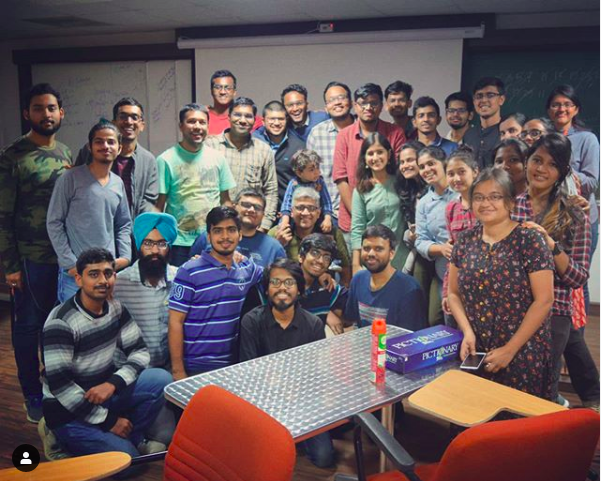

In [27]:
image=load_image(filename='testing_images/team.png')
plot_image(image)

First we need a reference to the tensor inside the Inception model which we will maximize in the DeepDream algorithm. In this case we select the entire 3rd layer of the Inception model (layer index 2). It has 192 channels and we 
will try and maximize the average value across all these channels.


In [28]:
layer_tensor = model.layer_tensors[1]
layer_tensor

<tf.Tensor 'conv2d1:0' shape=(?, ?, ?, 64) dtype=float32>

In [29]:
import time
start_time=time.time()
img_result = recursive_optimize(layer_tensor=layer_tensor, image=image,
                 num_iterations=5, step_size=3.0, rescale_factor=0.7,
                 num_repeats=2, blend=0.2)
print(time.time()-start_time)

Recursive level: 0
Processing image: 
. . . . . Recursive level: 1
Processing image: 
. . . . . Recursive level: 2
Processing image: 
. . . . . 2.6365697383880615


In [33]:
layer_tensor = model.layer_tensors[3]
img_result = recursive_optimize(layer_tensor=layer_tensor, image=image,
                 num_iterations=3, step_size=3.0, rescale_factor=0.7,
                 num_repeats=6, blend=0.2)

Recursive level: 0
Processing image: 
. . . Recursive level: 1
Processing image: 
. . . Recursive level: 2
Processing image: 
. . . Recursive level: 3
Processing image: 
. . . Recursive level: 4
Processing image: 
. . . Recursive level: 5
Processing image: 
. . . Recursive level: 6
Processing image: 
. . . 

In [83]:
layer_tensor = model.layer_tensors[9][:,:,:,0:2]
img_result = recursive_optimize(layer_tensor=layer_tensor, image=image,
                 num_iterations=10, step_size=3.0, rescale_factor=0.7,
                 num_repeats=4, blend=0.2)

Recursive level: 0
Processing image: 
. . . . . . . . . . Recursive level: 1
Processing image: 
. . . . . . . . . . Recursive level: 2
Processing image: 
. . . . . . . . . . Recursive level: 3
Processing image: 
. . . . . . . . . . Recursive level: 4
Processing image: 
. . . . . . . . . . 

In [25]:
layer_tensor = model.layer_tensors[10]
img_result = recursive_optimize(layer_tensor=layer_tensor, image=image,
                 num_iterations=10, step_size=3.0, rescale_factor=0.7,
                 num_repeats=4, blend=0.2)

Recursive level: 0
Processing image: 
. . . . . . . . . . Recursive level: 1
Processing image: 
. . . . . . . . . . Recursive level: 2
Processing image: 
. . . . . . . . . . Recursive level: 3
Processing image: 
. . . . . . . . . . Recursive level: 4
Processing image: 
. . . . . . . . . . 

In [35]:
layer_tensor = model.layer_tensors[10][:,:,:,0:3]
img_result = recursive_optimize(layer_tensor=layer_tensor, image=image,
                 num_iterations=10, step_size=3.0, rescale_factor=0.7,
                 num_repeats=4, blend=0.2)

Recursive level: 0
Processing image: 
. . . . . . . . . . Recursive level: 1
Processing image: 
. . . . . . . . . . Recursive level: 2
Processing image: 
. . . . . . . . . . Recursive level: 3
Processing image: 
. . . . . . . . . . Recursive level: 4
Processing image: 
. . . . . . . . . . 

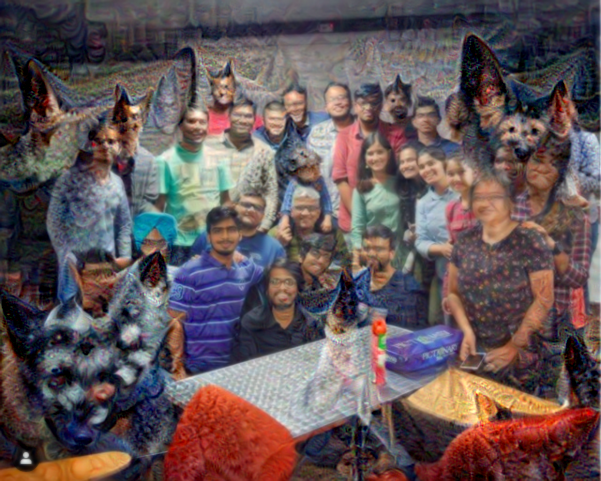

In [36]:
# To save the final Output 
plot_image(img_result)

image_save=save_image(img_result,"testing_images/check_output.jpg")

In [ ]:
# don't forget to have a look over the deep_dream_final_output.html file to see the processed outputs.